In [2]:
%load_ext autoreload
%autoreload 2

import os 
# os.environ['R_HOME']= r'C:\Users\tomha\miniconda3\envs\octagon_analysis\lib\R'
# os.environ['R_HOME']= r'D:\Users\Tom\miniconda3\envs\octagon_analysis\lib\R'
os.environ['R_HOME']= '/home/tom/miniconda3/envs/octagon_analysis/lib/R'

import rpy2

import rpy2.robjects as robjects
print(robjects.r('R.version.string'))

import parse_data.prepare_data as prepare_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import globals
import data_strings
import data_extraction.get_indices as get_indices
import analysis.wall_visibility_and_choice as wall_visibility_and_choice
from trajectory_analysis import trajectory_vectors
from plotting import plot_octagon
import parse_data.identify_filepaths as identify_filepaths 
from data_extraction.trial_list_filters import filter_trials_other_visible
from analysis import opponent_visibility
from ipywidgets import IntProgress
from IPython.display import display
import time
from pymer4.models import Lmer


[1] "R version 4.3.3 (2024-02-29)"



In [3]:
os.getcwd()

'/home/tom/repos/octagon_analysis/sandbox/glm'

In [4]:
# load data from left-one-out cross-validation
data_folder = os.path.join('..','data')

CV_dataset_names = [
    file for file in os.listdir(data_folder) if file.startswith('CV_results_solo') and file.endswith('.pickle')
]
print(CV_dataset_names)

ordered_datasets_names = [CV_dataset_names[-2], CV_dataset_names[0], CV_dataset_names[-1], CV_dataset_names[2], CV_dataset_names[1]]

print(ordered_datasets_names)


cross_validation_datasets = [
    pd.read_pickle(os.path.join(data_folder, file)) for file in ordered_datasets_names
]


['CV_results_solo_randomintercepts_randomd2l_400.pickle', 'CV_results_solo_randomintercepts_randomd2l_allinteractions_400.pickle', 'CV_results_solo_randomintercepts_randomd2l_midinteractions_400.pickle', 'CV_results_solo_randomintercepts_400.pickle', 'CV_results_solo_randomintercepts_randomd2l_lowinteractions_400.pickle']
['CV_results_solo_randomintercepts_400.pickle', 'CV_results_solo_randomintercepts_randomd2l_400.pickle', 'CV_results_solo_randomintercepts_randomd2l_lowinteractions_400.pickle', 'CV_results_solo_randomintercepts_randomd2l_midinteractions_400.pickle', 'CV_results_solo_randomintercepts_randomd2l_allinteractions_400.pickle']


In [5]:
# create plotting names
plotting_names = [
    'rand intercepts',
    'rand intercepts + d2l slopes',
    'interactions low',
    'interactions mid',
    'interactions high'
]

In [6]:
# extract and process nll
nlls = [ dataset['nll'] for dataset in cross_validation_datasets]

# divide nll by the number of models
nlls = [nll / len(dataset['random_indices']) for nll, dataset in zip(nlls, cross_validation_datasets)]

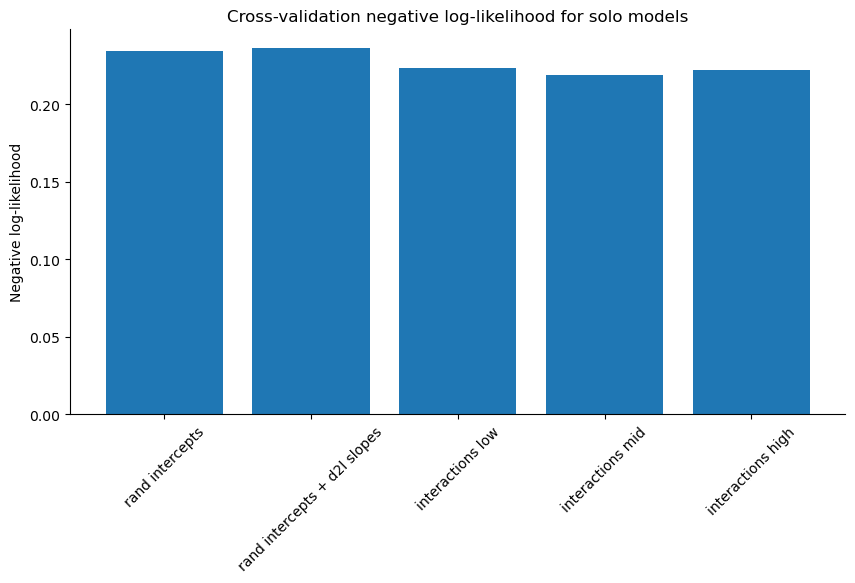

In [7]:
# plot nll barplot
plt.figure(figsize=(10, 5))
plt.bar(range(len(nlls)), nlls, tick_label=plotting_names)
plt.xticks(rotation=45)
plt.ylabel('Negative log-likelihood')
plt.title('Cross-validation negative log-likelihood for solo models')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# plt.tight_layout()

In [28]:
### extract predictions and ground truth
predictions = [dataset['predictions'] for dataset in cross_validation_datasets]
df = cross_validation_datasets[0]['dataframe']
random_indices = cross_validation_datasets[0]['random_indices']

# extract the ground truth
ground_truth = []
for dataset in cross_validation_datasets:
    ground_truth.append(dataset['dataframe'].loc[random_indices]['ChooseHigh'].values)

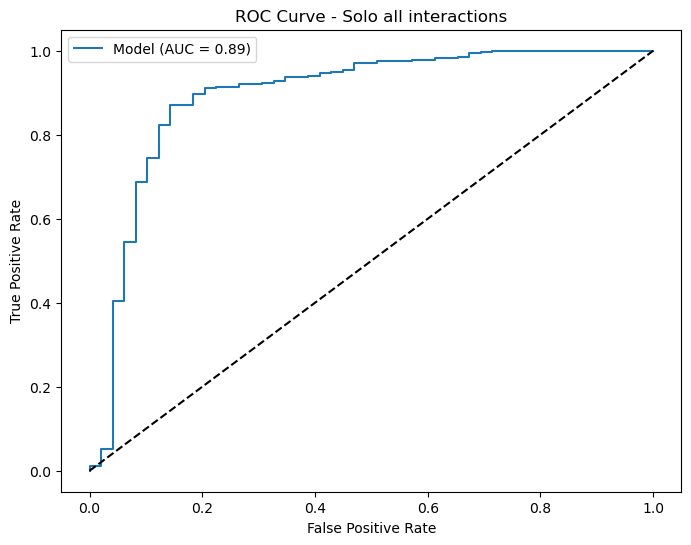

In [40]:
from sklearn.metrics import roc_curve, auc

# Example: Assuming `y_true` is the true labels and `y_scores` are model predictions
fpr, tpr, _ = roc_curve(ground_truth[0], predictions[0])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Solo all interactions')
plt.legend()
plt.show()